<a href="https://colab.research.google.com/github/Theophine/Time-series-forecasting-/blob/main/stock_price_prediction_(microsoft_stock_data).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import all libraries and dependencies for dataframe
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# import all libraries and dependencies for data visualization
plt.rcParams['figure.figsize'] = [8,8]
pd.set_option('display.max_columns', 500)
plt.style.use('ggplot')
sns.set(style='darkgrid')

In [2]:
from google.colab import files
uploaded = files.upload()

Saving daily_MSFT.csv to daily_MSFT.csv


In [3]:
import pandas as pd
import io
microsoft_data = pd.read_csv(io.BytesIO(uploaded['daily_MSFT.csv']))

#Access your data

NB: the currency in use is the USD

In [4]:
microsoft_data.head()

,timestamp,open,high,low,close,volume
0,02/01/1998,129.63,131.50,129.50,131.13,4968500
1,05/01/1998,131.25,133.63,127.87,130.38,10047200
2,06/01/1998,129.75,133.00,129.25,131.13,8479300
3,07/01/1998,129.88,131.19,127.50,129.56,7686600
4,08/01/1998,128.63,132.13,127.50,130.50,9702400


In [5]:
#Get more information about the data
print(microsoft_data.info())
print(microsoft_data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5284 entries, 0 to 5283
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  5284 non-null   object 
 1   open       5284 non-null   float64
 2   high       5284 non-null   float64
 3   low        5284 non-null   float64
 4   close      5284 non-null   float64
 5   volume     5284 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 247.8+ KB
None
              open         high          low        close        volume
count  5284.000000  5284.000000  5284.000000  5284.000000  5.284000e+03
mean     48.978040    49.581173    48.375030    48.990096  4.753600e+07
std      29.385947    29.837548    28.907801    29.404061  2.883750e+07
min      15.200000    15.620000    14.870000    15.150000  3.458100e+06
25%      27.060000    27.290000    26.867500    27.089875  2.798192e+07
50%      34.720000    35.020000    34.375000    34.727500  4.279235e+07
7

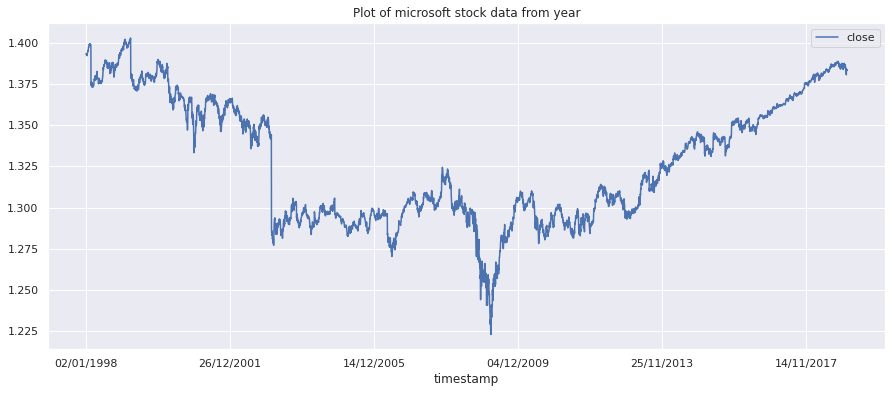

In [46]:
#view a quick plot of the closing price
#microsoft_data[1260: 1600].plot(x = 'timestamp', y = 'close', figsize = (15, 6));
microsoft_data.plot(x = 'timestamp', y = 'close', figsize = (15, 6));
plt.title('Plot of microsoft stock data from year');
plt.show();

Observation, the trend is a logistic curve (non-linear)

#data inspection

In [7]:
#check that the data is clean
microsoft_data.isnull().sum()

timestamp    0
open         0
high         0
low          0
close        0
volume       0
dtype: int64

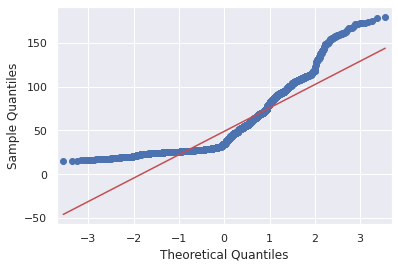

In [8]:
#check if the data of interest (close) is normally distributed 
import statsmodels.api as sm
sm.qqplot(microsoft_data['close'], line = 'r')
plt.show();

our data is not normally distributed. Therefore, we need to perform a boxcox transformation 

In [9]:
from scipy.stats import boxcox
from scipy.special import inv_boxcox

In [10]:
#tranforming our data using boxcox
microsoft_data['close'], lambd = boxcox(microsoft_data['close'])

In [11]:
print('The value of lambda is ', lambd)

The value of lambda is  -0.6934089523239858


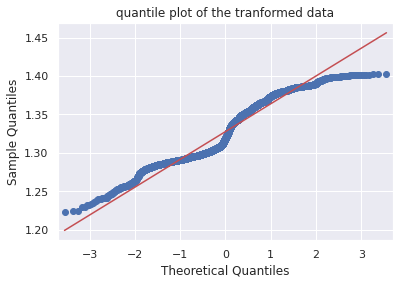

In [12]:
#check if the data has been tranformed to fit a normal distribution 
sm.qqplot(microsoft_data['close'], line = 'r')
plt.title('quantile plot of the tranformed data')
plt.show()

#modelling time

In [13]:
#extract the needed columns and put in a new dataframe 

data = microsoft_data[['timestamp', 'close']]

In [14]:
#rename the column names 
data.columns = ['ds', 'y']

#check code 
data.head()

,ds,y
0,02/01/1998,1.393107
1,05/01/1998,1.392912
2,06/01/1998,1.393107
3,07/01/1998,1.392696
4,08/01/1998,1.392943


In [15]:
#instantiate the prophet model
from fbprophet import Prophet

In [16]:
model = Prophet(growth = 'logistic', daily_seasonality= False, weekly_seasonality= False, yearly_seasonality= True, seasonality_mode= 'additive')

data['cap'] = data['y'].max() + data['y'].std() * 0.05

model.fit(data)

future = model.make_future_dataframe(periods = 365)
future['cap'] = data['cap'].max()

forecast = model.predict(future)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


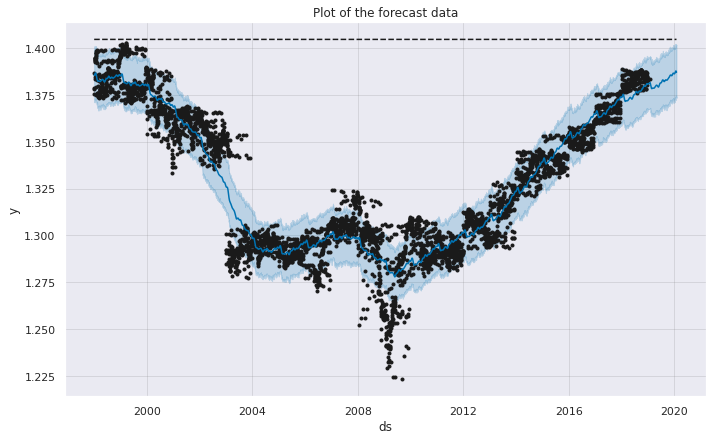

In [17]:
model.plot(forecast);
plt.title('Plot of the forecast data')
plt.show();


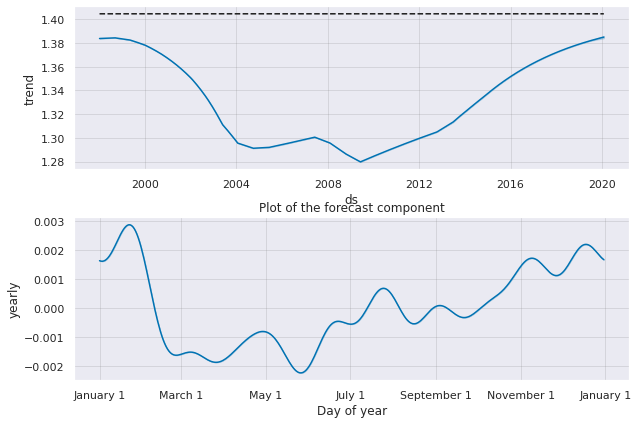

In [18]:
model.plot_components(forecast);
plt.title('Plot of the forecast component')
plt.show();


In [19]:
#Building a new model; include monthly seasonality and special events (or holidays)
new_model = Prophet(growth = 'logistic', daily_seasonality= False, weekly_seasonality= False, yearly_seasonality= True, seasonality_mode= 'additive')

#below is the code to add seasonality 
new_model.add_seasonality(name = 'monthly', period = 30, fourier_order= 10, mode = 'additive')

#below is code for quarterly seasonality 
new_model.add_seasonality(name = 'quarterly', period = 92.25, fourier_order= 10, mode = 'additive')

#below is the code to add country holidays
new_model.add_country_holidays(country_name= 'US')


In [20]:
prophet_model_sea = new_model.fit(data)

future_sea = new_model.make_future_dataframe(periods = 365, freq = 'D')
future_sea['cap'] = data['cap'].max()

forecast_sea = prophet_model_sea.predict(future_sea)

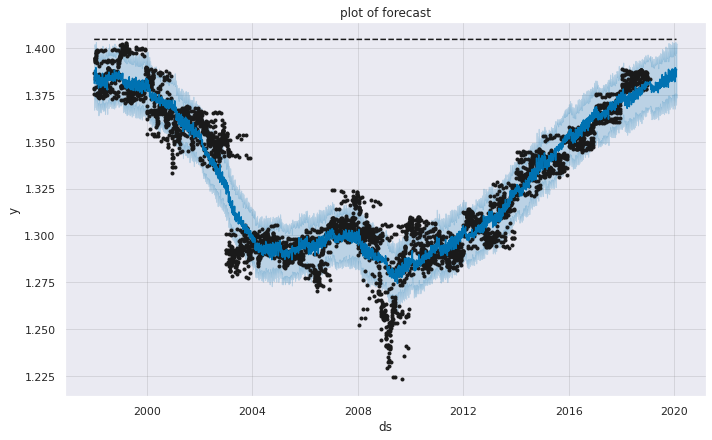

In [21]:
#plot the forecast plot and also the plot component

prophet_model_sea.plot(forecast_sea)
plt.title('plot of forecast')
plt.show();

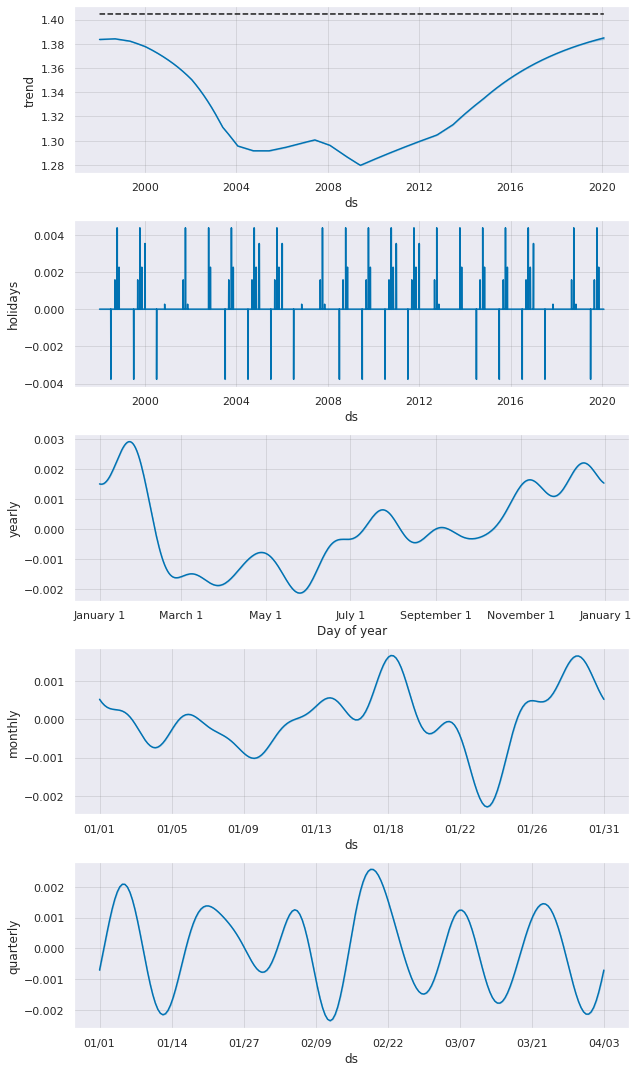

In [22]:
#plot the forecast components
prophet_model_sea.plot_components(forecast_sea)
plt.show();

#Hyperparameter tunning

In [23]:
import itertools
from fbprophet.diagnostics import cross_validation, performance_metrics

In [24]:
param_grid = {
    'daily_seasonality': [False],
    'weekly_seasonality': [False],
    'yearly_seasonality': [True],
    'growth': ['logistic'],
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0]
}

#generate all combinations of parameters and put them in different dictionaries
#we would loop through the dictionary 
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
print(all_params)

[{'daily_seasonality': False, 'weekly_seasonality': False, 'yearly_seasonality': True, 'growth': 'logistic', 'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01}, {'daily_seasonality': False, 'weekly_seasonality': False, 'yearly_seasonality': True, 'growth': 'logistic', 'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1}, {'daily_seasonality': False, 'weekly_seasonality': False, 'yearly_seasonality': True, 'growth': 'logistic', 'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0}, {'daily_seasonality': False, 'weekly_seasonality': False, 'yearly_seasonality': True, 'growth': 'logistic', 'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0}, {'daily_seasonality': False, 'weekly_seasonality': False, 'yearly_seasonality': True, 'growth': 'logistic', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}, {'daily_seasonality': False, 'weekly_seasonality': False, 'yearly_seasonality': True, 'growth': 'logistic', 'changepoint_p

In [25]:
rmses = list()

for params in all_params:
  #time to re-build the model and test all possible combinations of parameters 
  hyper_model = Prophet(**params)

  #below is the code to add seasonality 
  hyper_model.add_seasonality(name = 'monthly', period = 30.5, fourier_order= 10, mode = 'additive')

  #below is code for quarterly seasonality 
  hyper_model.add_seasonality(name = 'quarterly', period = 92.25, fourier_order= 10, mode = 'additive')

  #below is the code to add country holidays
  hyper_model.add_country_holidays(country_name= 'US')

  hyper_prophet_model = hyper_model.fit(data)

  future_hyper = hyper_model.make_future_dataframe(periods = 365, freq = 'D')
  future_hyper['cap'] = data['cap'].max()

  hyper_forecast = hyper_prophet_model.predict(future_sea)

  #cross validate the model to view its forecasting accuracy 
  df_cv = cross_validation(hyper_prophet_model, initial = '730 days', period = '365 days', horizon = '365 days', parallel = 'processes')

  df_p = performance_metrics(df_cv)

  rmses.append(df_p['rmse'].values[0])

#find the best parameters 
tunning_result = pd.DataFrame(all_params)
tunning_result['rmse'] = rmses
print(tunning_result)

INFO:fbprophet:Making 19 forecasts with cutoffs between 2000-02-06 00:00:00 and 2018-02-01 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f90750c09d0>
INFO:fbprophet:Making 19 forecasts with cutoffs between 2000-02-06 00:00:00 and 2018-02-01 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f908cc94e90>
INFO:fbprophet:Making 19 forecasts with cutoffs between 2000-02-06 00:00:00 and 2018-02-01 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f908dad2710>
INFO:fbprophet:Making 19 forecasts with cutoffs between 2000-02-06 00:00:00 and 2018-02-01 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f908bf92210>
INFO:fbprophet:Making 19 forecasts with cutoffs between 2000-02-06 00:00:00 and 2018-02-01 00:00:00
INFO:fbprophet:Applying in parallel with

    daily_seasonality  weekly_seasonality  yearly_seasonality    growth  \
0               False               False                True  logistic   
1               False               False                True  logistic   
2               False               False                True  logistic   
3               False               False                True  logistic   
4               False               False                True  logistic   
5               False               False                True  logistic   
6               False               False                True  logistic   
7               False               False                True  logistic   
8               False               False                True  logistic   
9               False               False                True  logistic   
10              False               False                True  logistic   
11              False               False                True  logistic   
12              False    

In [27]:
#Find the combination that gives the best optimization (i.e., the lowest rmse value)
all_params[np.argmin(rmses)]

{'changepoint_prior_scale': 0.5,
 'daily_seasonality': False,
 'growth': 'logistic',
 'seasonality_prior_scale': 0.1,
 'weekly_seasonality': False,
 'yearly_seasonality': True}

In [28]:
#now we can build the forecast model with the above combination
new_param = {'changepoint_prior_scale': 0.5,
 'daily_seasonality': False,
 'growth': 'logistic',
 'seasonality_prior_scale': 0.1,
 'weekly_seasonality': False,
 'yearly_seasonality': True}

#Build a new model with the tunned parameters

In [30]:
#time to re-build the model and test all possible combinations of parameters 
new_model = Prophet(**new_param)

#below is the code to add seasonality 
new_model.add_seasonality(name = 'monthly', period = 30.5, fourier_order= 10, mode = 'additive')

#below is code for quarterly seasonality 
new_model.add_seasonality(name = 'quarterly', period = 92.25, fourier_order= 10, mode = 'additive')

#below is the code to add country holidays
new_model.add_country_holidays(country_name= 'US')

new_prophet_model = new_model.fit(data)

future_new = new_model.make_future_dataframe(periods = 365, freq = 'D')
future_new['cap'] = data['cap'].max()

future_forecast = new_prophet_model.predict(future_new)

#cross validate the model to view its forecasting accuracy 
df_cv = cross_validation(new_prophet_model, initial = '730 days', period = '365 days', horizon = '365 days')

df_p = performance_metrics(df_cv)

INFO:fbprophet:Making 19 forecasts with cutoffs between 2000-02-06 00:00:00 and 2018-02-01 00:00:00


##plot the new forecast and its components

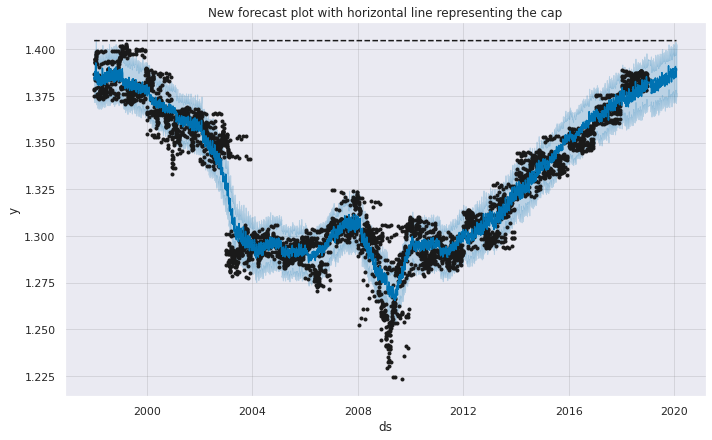

In [32]:
new_prophet_model.plot(future_forecast)
plt.title('New forecast plot with horizontal line representing the cap')
plt.show();

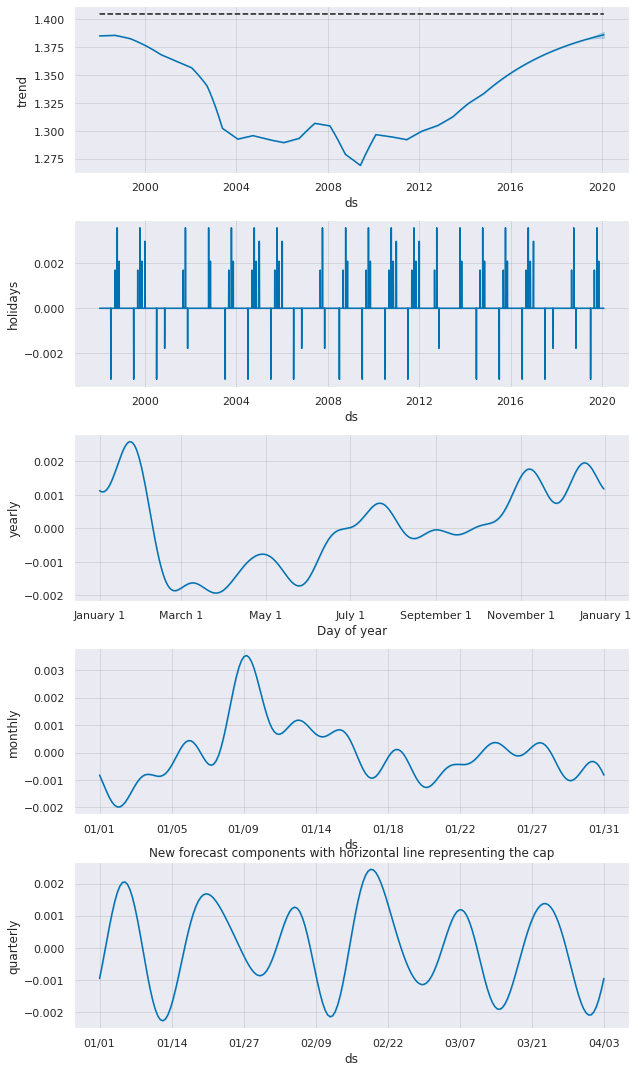

In [33]:
new_prophet_model.plot_components(future_forecast)
plt.title('New forecast components with horizontal line representing the cap')
plt.show();

In [34]:
#plot the change points 
from fbprophet.plot import add_changepoints_to_plot

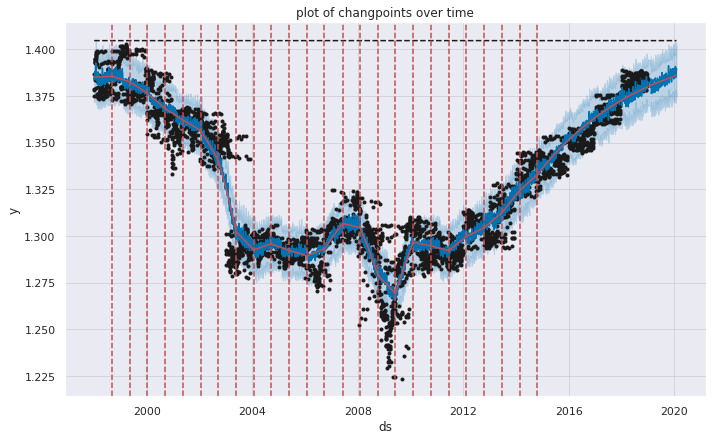

In [35]:
fig = new_prophet_model.plot(future_forecast)
add_changepoints_to_plot(fig.gca(), new_prophet_model, future_forecast)
plt.title('plot of changpoints over time')
plt.show();

In [36]:
#print our the performance values 
df_p.mean()

horizon     201 days 12:00:00
mse               0.000549021
rmse                0.0230262
mae                 0.0166691
mape                 0.012694
mdape              0.00837553
coverage             0.579135
dtype: object

##convert the boxcox prediction back to the original prediction 

In [39]:
future_forecast['yhat'] = inv_boxcox(future_forecast['yhat'],  lambd)
future_forecast['yhat_lower'] = inv_boxcox(future_forecast['yhat_lower'],  lambd)
future_forecast['yhat_upper'] = inv_boxcox(future_forecast['yhat_upper'],  lambd)


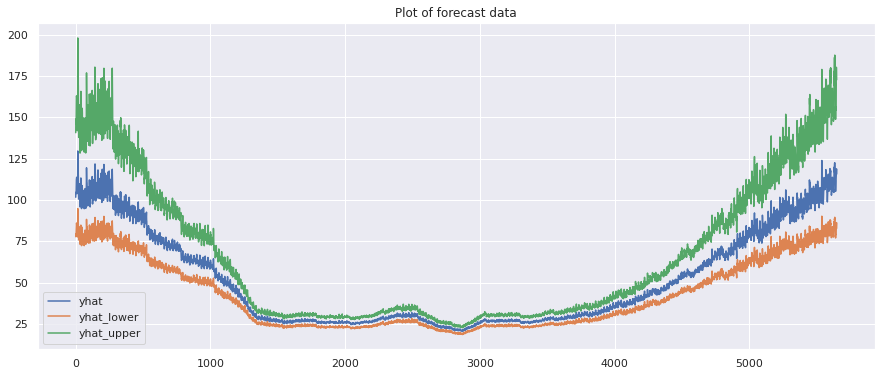

In [43]:
future_forecast[['yhat', 'yhat_lower', 'yhat_upper']].plot(figsize = (15, 6))
plt.title('Plot of forecast data')
plt.show();